REDES NEURONALES

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo seleccionado: {device}")


Dispositivo seleccionado: cuda


In [45]:
# Cargar dataset
df = pd.read_excel("American Ninja Warrior Obstacle History.xlsx")
df.columns = df.columns.str.strip().str.replace(" ", "_")
df = df.sort_values(by=["Obstacle_Name", "Season"])

# Crear columna con pr√≥xima temporada del obst√°culo
df["siguiente_temp"] = df.groupby("Obstacle_Name")["Season"].shift(-1)

# Etiqueta: volvi√≥ en la siguiente temporada
df["vuelve_en_siguiente"] = (df["siguiente_temp"] == df["Season"] + 1).astype(int)

# Filtrar filas v√°lidas
df_entrenamiento = df.dropna(subset=["siguiente_temp"]).copy()

# Crear caracter√≠sticas agregadas
df_entrenamiento["apariciones_previas"] = df_entrenamiento.groupby("Obstacle_Name")["Season"].transform("count")
df_entrenamiento["orden_promedio"] = df_entrenamiento.groupby("Obstacle_Name")["Obstacle_Order"].transform("mean")
df_entrenamiento["etapas_diferentes"] = df_entrenamiento.groupby("Obstacle_Name")["Round/Stage"].transform("nunique")
df_entrenamiento["ubicaciones_diferentes"] = df_entrenamiento.groupby("Obstacle_Name")["Location"].transform("nunique")


In [160]:
X = df_entrenamiento[[
    "Season", "Obstacle_Order", "apariciones_previas",
    "orden_promedio", "etapas_diferentes", "ubicaciones_diferentes"
]]
y = df_entrenamiento["vuelve_en_siguiente"]

# Dividir
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a tensores
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


In [154]:
class MLPBinario(nn.Module):
    def __init__(self, input_size):
        super(MLPBinario, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)


In [155]:
class MLPRondas(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, num_classes)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x  # logits para CrossEntropyLoss


In [161]:
modelo = MLPBinario(input_size=X_train_tensor.shape[1]).to(device)
criterio = nn.CrossEntropyLoss()
optimizador = optim.Adam(modelo.parameters(), lr=0.003, weight_decay=1e-5)


In [162]:
def entrenar_modelo(modelo, train_loader, test_loader, criterio, optimizador, epocas=30):
    historial = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    for epoca in range(epocas):
        modelo.train()
        loss_total, correctos, total = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizador.zero_grad()
            salida = modelo(X_batch).squeeze()
            loss = criterio(salida, y_batch)
            loss.backward()
            optimizador.step()
            
            loss_total += loss.item()
            pred = (salida > 0.5).float()
            correctos += (pred == y_batch).sum().item()
            total += y_batch.size(0)
        
        acc_train = 100 * correctos / total
        historial["train_loss"].append(loss_total / len(train_loader))
        historial["train_acc"].append(acc_train)

        # Validaci√≥n
        modelo.eval()
        val_loss, val_correctos, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                salida = modelo(X_batch).squeeze()
                loss = criterio(salida, y_batch)
                val_loss += loss.item()
                pred = (salida > 0.5).float()
                val_correctos += (pred == y_batch).sum().item()
                val_total += y_batch.size(0)
        
        acc_val = 100 * val_correctos / val_total
        historial["val_loss"].append(val_loss / len(test_loader))
        historial["val_acc"].append(acc_val)

        print(f"√âpoca {epoca+1}: Precisi√≥n entrenamiento {acc_train:.2f}%, validaci√≥n {acc_val:.2f}%")
    
    return historial


√âpoca 1: Precisi√≥n entrenamiento 55.56%, validaci√≥n 65.41%
√âpoca 2: Precisi√≥n entrenamiento 63.65%, validaci√≥n 72.18%
√âpoca 3: Precisi√≥n entrenamiento 66.67%, validaci√≥n 71.43%
√âpoca 4: Precisi√≥n entrenamiento 69.11%, validaci√≥n 68.42%
√âpoca 5: Precisi√≥n entrenamiento 69.30%, validaci√≥n 72.18%
√âpoca 6: Precisi√≥n entrenamiento 66.67%, validaci√≥n 69.17%
√âpoca 7: Precisi√≥n entrenamiento 69.68%, validaci√≥n 73.68%
√âpoca 8: Precisi√≥n entrenamiento 69.49%, validaci√≥n 72.93%
√âpoca 9: Precisi√≥n entrenamiento 67.98%, validaci√≥n 68.42%
√âpoca 10: Precisi√≥n entrenamiento 67.23%, validaci√≥n 70.68%
√âpoca 11: Precisi√≥n entrenamiento 66.29%, validaci√≥n 69.92%
√âpoca 12: Precisi√≥n entrenamiento 66.29%, validaci√≥n 70.68%
√âpoca 13: Precisi√≥n entrenamiento 68.74%, validaci√≥n 72.18%
√âpoca 14: Precisi√≥n entrenamiento 67.61%, validaci√≥n 74.44%
√âpoca 15: Precisi√≥n entrenamiento 69.87%, validaci√≥n 70.68%
√âpoca 16: Precisi√≥n entrenamiento 66.48%, validaci√≥n 72.18%
√

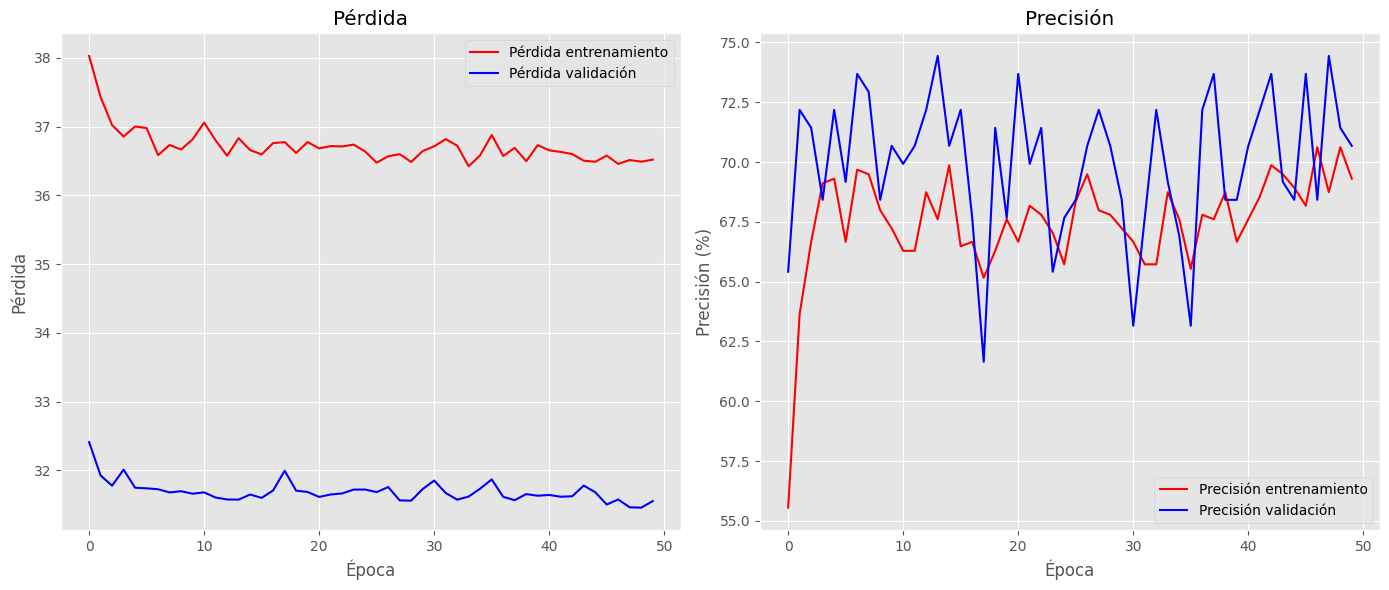

In [163]:
historial = entrenar_modelo(modelo, train_loader, test_loader, criterio, optimizador, epocas=50)

# Gr√°fica de p√©rdida y precisi√≥n lado a lado
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(historial["train_loss"], label="P√©rdida entrenamiento", color="red")
plt.plot(historial["val_loss"], label="P√©rdida validaci√≥n", color="blue")
plt.title("P√©rdida")
plt.xlabel("√âpoca")
plt.ylabel("P√©rdida")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historial["train_acc"], label="Precisi√≥n entrenamiento", color="red")
plt.plot(historial["val_acc"], label="Precisi√≥n validaci√≥n", color="blue")
plt.title("Precisi√≥n")
plt.xlabel("√âpoca")
plt.ylabel("Precisi√≥n (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [123]:
# Selecci√≥n aleatoria de obst√°culo
import random
nombre = random.choice(df["Obstacle_Name"].unique())
historial = df[df["Obstacle_Name"] == nombre]
ultima = historial.sort_values(by="Season", ascending=False).iloc[0]

# Simular temporada 11
entrada = pd.DataFrame([{
    "Season": 11,
    "Obstacle_Order": historial["Obstacle_Order"].mean(),
    "apariciones_previas": historial["Season"].count(),
    "orden_promedio": historial["Obstacle_Order"].mean(),
    "etapas_diferentes": historial["Round/Stage"].nunique(),
    "ubicaciones_diferentes": historial["Location"].nunique()
}])

entrada_escalada = scaler.transform(entrada)
entrada_tensor = torch.FloatTensor(entrada_escalada).to(device)

modelo.eval()
with torch.no_grad():
    prob = modelo(entrada_tensor).item()
    pred_binaria = int(prob > 0.5)

print(f"üîç Obst√°culo: {nombre}")
print(f"üìÖ √öltima aparici√≥n: Temporada {int(ultima['Season'])}")
print(f"üîÆ Probabilidad de aparecer en T11: {prob:.2%}")
print(f"‚úÖ Predicci√≥n: {'S√≠ aparecer√°' if pred_binaria else 'No aparecer√°'}")


üîç Obst√°culo: Spider Trap
üìÖ √öltima aparici√≥n: Temporada 10
üîÆ Probabilidad de aparecer en T11: 18.91%
‚úÖ Predicci√≥n: No aparecer√°
